In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Define the data_directory of preprocessed data

In [2]:
data_directory = "C:/Users/kwokp/OneDrive/Desktop/Study/zzz_application project/Final/data_after_preprocessing.csv"

### We devide the data into 3 groups:
* Group 1: full data
* Group 2: data with four large categories which have more than 1000 companies each
* Group 3: seven categories of data, number of companies in each category is same but small

### In the function selectGroup, giving 1, 2 or 3 as input parameter to selet the relevant data for experiment

In [3]:
# read the data from directory, then select the group 
# of data we want to process.
def selectGroup(directory, group_nr):
    data = pd.read_csv(directory, sep='\t')
    if group_nr == 1:
        return data
    if group_nr == 2:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=1041,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=1041,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=1041,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=1041,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group])
        return df_clean.sample(frac=1)
    if group_nr == 3:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=219,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=219,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=219,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=219,replace=False)
        df_industry_goods=data[data['Category'] == 'INDUSTRIAL GOODS & MATERIALS GROUP'].sample(n=219,replace=False)
        df_consumer_goods=data[data['Category'] == 'CONSUMER GOODS GROUP'].sample(n=219,replace=False)
        df_energy=data[data['Category'] == 'ENERGY & UTILITIES GROUP'].sample(n=219,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group,df_industry_goods,df_consumer_goods,df_energy])
        return df_clean.sample(frac=1)

In [4]:
# use tf-idf methode to generate scores for each company
def tf_idf_func(df_document, max_features):
    feature_extraction = TfidfVectorizer(max_features = max_features, stop_words = 'english')
    score_matrix = feature_extraction.fit_transform(df_document.values)
    return score_matrix, feature_extraction

In [5]:
# get the top_n words
def get_top_keywords(scores_matrix, clusters, labels, n_terms):
    df = pd.DataFrame(scores_matrix.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))    


### We use original data which appears in multiple category . Main steps are as follows:
1. select the group of data to do the test
2. generate TF-IDF score matrix



Cluster BUSINESS & FINANCIAL SERVICES
company,website,time,site,service,business,use,data,services,information

Cluster CONSUMER GOODS GROUP
time,service,product,food,new,site,website,products,use,information

Cluster CONSUMER SERVICES GROUP
new,website,time,terms,content,service,site,services,use,information

Cluster ENERGY & UTILITIES GROUP
renewable,company,water,information,fuel,power,oil,gas,solar,energy

Cluster HEALTHCARE GROUP
site,healthcare,use,patient,care,health,clinical,patients,information,medical

Cluster INDUSTRIAL GOODS & MATERIALS GROUP
quality,customers,com,company,packaging,site,use,manufacturing,information,products

Cluster INFORMATION TECHNOLOGY GROUP
solutions,site,time,business,software,service,services,use,data,information


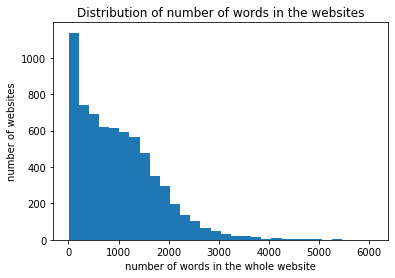

In [6]:
#get the data, remove the frequent words which appear in more than one category, and update the tf-idf score matrix
data = selectGroup(data_directory, 1)
score_matrix, feature_extraction = tf_idf_func(data['clean'], 8000)

#show the top keywords 
get_top_keywords(score_matrix, data['Category'].values, feature_extraction.get_feature_names(), 10)

# count the non-zero words from updated tf-idf score matrix and display the non-zero word count in each company website
score_value = score_matrix.todense()
website_word_count=np.asarray(np.count_nonzero(score_value, axis=1)).reshape(-1)
plt.hist(website_word_count, bins = 30)
plt.xlabel('number of words in the whole website')
plt.ylabel('number of websites')
plt.title('Distribution of number of words in the websites')

df_score=pd.DataFrame(score_value)
df_score.columns=feature_extraction.get_feature_names()
df_score['Category'] = data['Category'].reset_index(drop=True)
df_score['Category'].value_counts()
df_score_valid = df_score

### Split the data 80% for training and 20% for testing

In [7]:
df_final = df_score_valid[df_score_valid.columns.difference(['Category'])] #remove columns'Keep' and 'Category'

df_category = df_score_valid['Category'].reset_index(drop=True)

msk = np.random.rand(len(df_final)) < 0.8
train_x = np.nan_to_num(df_final[msk])
test_x = np.nan_to_num(df_final[~msk])
train_y = df_category[msk].to_numpy()
test_y = df_category[~msk].to_numpy()

### Perform Linear SVM

start svm
[[175   3  43   1   8   8  91]
 [  8  41  18   2   2   5   8]
 [ 32  11 133   0   9   2  42]
 [ 11   1   2  23   2   1   5]
 [ 12   8   7   0 160   4  17]
 [  9   8   5   2   2  61  17]
 [ 76   2  35   2  14  12 256]]
                                    precision    recall  f1-score   support

     BUSINESS & FINANCIAL SERVICES       0.54      0.53      0.54       329
              CONSUMER GOODS GROUP       0.55      0.49      0.52        84
           CONSUMER SERVICES GROUP       0.55      0.58      0.56       229
          ENERGY & UTILITIES GROUP       0.77      0.51      0.61        45
                  HEALTHCARE GROUP       0.81      0.77      0.79       208
INDUSTRIAL GOODS & MATERIALS GROUP       0.66      0.59      0.62       104
      INFORMATION TECHNOLOGY GROUP       0.59      0.64      0.61       397

                          accuracy                           0.61      1396
                         macro avg       0.64      0.59      0.61      1396
          

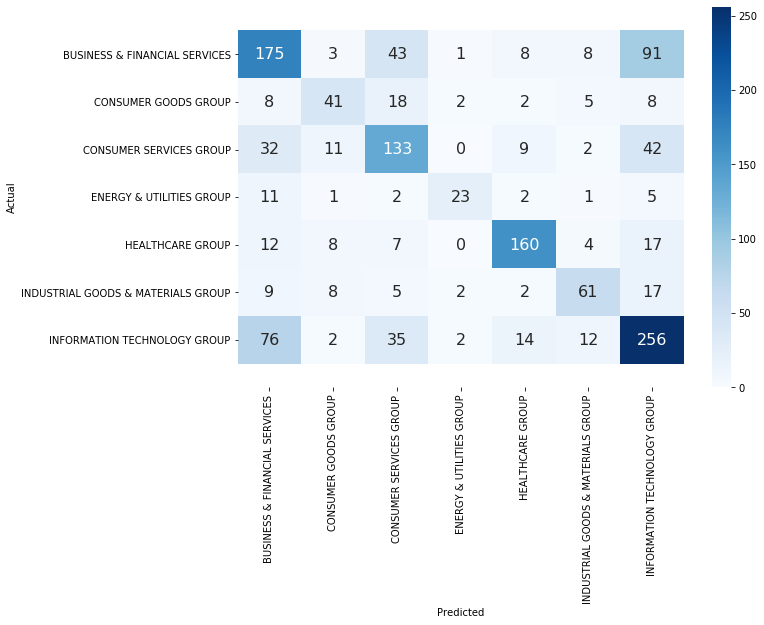

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#use svm classifier to classify TF-IDF of each website
def linear_svc_classifier(train_x, train_y, test_x, test_y):
    print("start svm")
    classifier_svm = svm.LinearSVC()
    classifier_svm.fit(train_x, train_y)
    predictions = classifier_svm.predict(test_x)
     
    print(confusion_matrix(test_y, predictions))
    print(classification_report(test_y, predictions))
    print(accuracy_score(test_y, predictions))
    
    array = confusion_matrix(test_y, predictions)
    
  
    y_true = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP", "ENERGY & UTILITIES GROUP","HEALTHCARE GROUP", "INDUSTRIAL GOODS & MATERIALS GROUP","INFORMATION TECHNOLOGY GROUP"]
 
    y_pred = y_true
    df_cm = pd.DataFrame(array, y_true, y_pred)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    #sn.set(font_scale=1.4)#for label size
    ax=sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d',annot_kws={"size": 16})# font size
    bottom, top=ax.get_ylim()
    ax.set_ylim(bottom+0.5, top-0.5)
    ax.tick_params(labelsize=10) 
    plt.show()
    
    return confusion_matrix(test_y, predictions),predictions

confusion_matrix, predictions = linear_svc_classifier(train_x, train_y, test_x, test_y)

### Perform KNN with 5 Neighbours

start knn
[[189   3  33   2  11   6  85]
 [ 17  36  14   2   5   0  10]
 [ 47  15 118   0   9   0  40]
 [ 10   2   1  23   2   5   2]
 [ 32   6   3   0 146   3  18]
 [ 27   5  11   5   1  38  17]
 [132   2  39   2   9   8 205]]
                                    precision    recall  f1-score   support

     BUSINESS & FINANCIAL SERVICES       0.42      0.57      0.48       329
              CONSUMER GOODS GROUP       0.52      0.43      0.47        84
           CONSUMER SERVICES GROUP       0.54      0.52      0.53       229
          ENERGY & UTILITIES GROUP       0.68      0.51      0.58        45
                  HEALTHCARE GROUP       0.80      0.70      0.75       208
INDUSTRIAL GOODS & MATERIALS GROUP       0.63      0.37      0.46       104
      INFORMATION TECHNOLOGY GROUP       0.54      0.52      0.53       397

                          accuracy                           0.54      1396
                         macro avg       0.59      0.52      0.54      1396
          

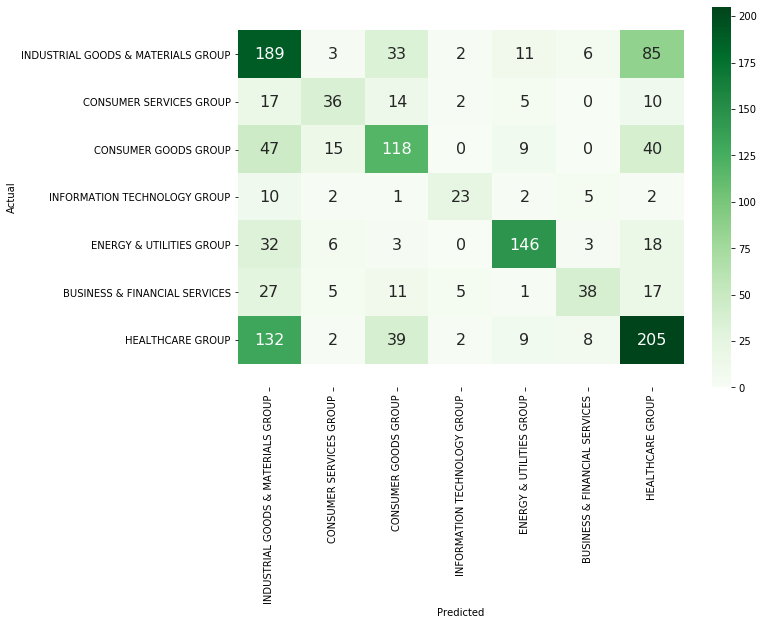

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#use knn classifier to classify TF-IDF of each website
def knn_classifier(x_train, y_train, x_test, y_test):
    print("start knn")
    modelknn = KNeighborsClassifier(n_neighbors=5)
    modelknn.fit(x_train, y_train)
    predictions = modelknn.predict(x_test)

    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    print(accuracy_score(y_test, predictions))
    
    array = confusion_matrix(y_test, predictions)
    
    y_true = ["INDUSTRIAL GOODS & MATERIALS GROUP", "CONSUMER SERVICES GROUP","CONSUMER GOODS GROUP","INFORMATION TECHNOLOGY GROUP","ENERGY & UTILITIES GROUP","BUSINESS & FINANCIAL SERVICES", "HEALTHCARE GROUP"]
             
    y_pred = y_true
    df_cm = pd.DataFrame(array, y_true, y_pred)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    #sn.set(font_scale=1.4)#for label size
    ax=sn.heatmap(df_cm, cmap="Greens", annot=True, fmt='d',annot_kws={"size": 16})# font size
    bottom, top=ax.get_ylim()
    ax.set_ylim(bottom+0.5, top-0.5)
    ax.tick_params(labelsize=10) 
    plt.show()

    return confusion_matrix(test_y, predictions),predictions

confusion_matrix, predictions = knn_classifier(train_x, train_y, test_x, test_y)

### Perform K means and Plot SSE, PCA and TSNE

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters

Cluster 0
background,height,var,font,color,border,width,padding,margin,px

Cluster 1
content,terms,personal,service,privacy,data,services,site,use,information

Cluster 2
site,product,service,company,use,information,new,energy,com,products

Cluster 3
site,dns,online,com,web,domains,website,hosting,wordpress,domain

Cluster 4
use,lending,financial,lender,information,lenders,credit,loans,mortgage,loan

Cluster 5
dr,treatment,cancer,healthcare,care,patient,health,medical,clinical,patients

Cluster 6
solutions,management,service,use,time,new,services,business,information,data
(2, 3, 0, 6, 4, 1, 5)
The Accuracy is 0.34


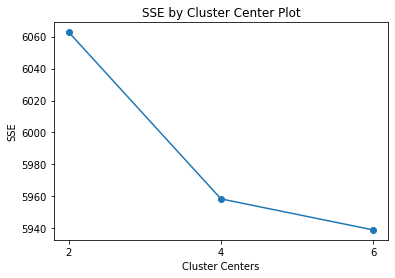

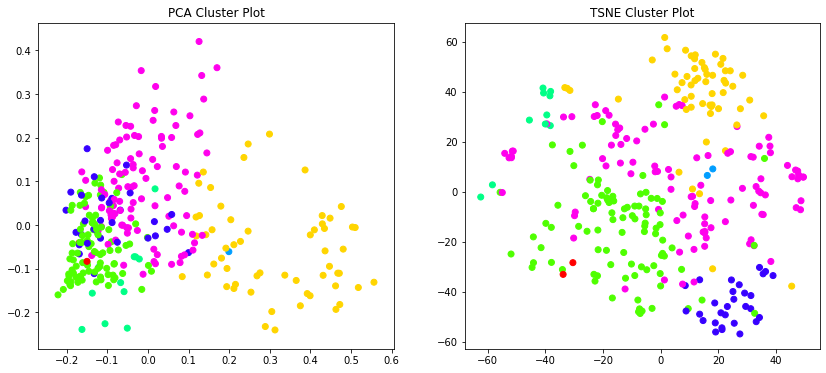

In [10]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import itertools

#Find the optimal clusters from 2 to maximum of clusters of data group, plot respective SSE.
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=512, batch_size=1024, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

#Plot TSNE and PCA for the clusters    
def plot_tsne_pca(data, labels):
    max_label = max(labels+1)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

#Calculate the accuracy of the clustered data and actual label     
def Calculate_accuracy(clusters, actual_label):
    count = 0
    for index, cluster in enumerate(clusters):
        if cluster==actual_label[index]:
            count+=1
    accuracy = count/len(clusters)*1.0
    return accuracy

#Assign clisters for the clustered data
def assign_clusters(original_label, permu, nr_group):
    if nr_group == 2:
        categories = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER SERVICES GROUP", "HEALTHCARE GROUP", "INFORMATION TECHNOLOGY GROUP"]
    else:
        categories = ["INDUSTRIAL GOODS & MATERIALS GROUP", "CONSUMER SERVICES GROUP","CONSUMER GOODS GROUP","INFORMATION TECHNOLOGY GROUP","ENERGY & UTILITIES GROUP","BUSINESS & FINANCIAL SERVICES", "HEALTHCARE GROUP"]
    mydict=dict(zip(categories, permu))
    actual_label = np.zeros(len(original_label))
    for index, label in enumerate(original_label):
        actual_label[index] = mydict[label]
    return actual_label

#Perform Kmeans and Plot
def kmeans_classifier(score_matrix_update, nr_group):
    if nr_group == 2:
        nr_cluster = 4
    else:
        nr_cluster = 7
    find_optimal_clusters(score_matrix_update, nr_cluster)
    clusters = MiniBatchKMeans(n_clusters=nr_cluster, init_size=512, batch_size=1024, random_state=20).fit_predict(score_matrix_update)
    plot_tsne_pca(score_matrix_update, clusters)
    get_top_keywords(score_matrix_update, clusters, feature_extraction.get_feature_names(), 10)

    if nr_group == 2:
        numbers=[0,1,2,3]
    else:
        numbers = [0,1,2,3,4,5,6]
    permu = list(itertools.permutations(numbers))
    best_accuracy = 0
    for i in range(len(permu)):
        actual_label = assign_clusters(data['Category'].values, permu[i], nr_group)
        accuracy = Calculate_accuracy(clusters, actual_label)
        if best_accuracy<accuracy:
            best_accuracy=accuracy
            final_label = actual_label
            category = permu[i]
        else: 
            best_accuracy=best_accuracy

    print(category)
    #print(final_label)
    print("The Accuracy is " + str(round(best_accuracy,2)))

kmeans_classifier(score_matrix, 1)    

### Perform Feedforward Neural Network

In [11]:
#Split dataset into training, validation and test
def convert_num(categories):
    num_dict = {}
    num = 0
    for category in categories:
        num_dict[category] = num
        num = num+1
    return num_dict

mapping = convert_num(data['Category'].unique())
match_1 = data.replace({'Category': mapping})

score_matrix, feature_extraction = tf_idf_func(data['clean'], 8000)

num_training = int(score_matrix.shape[0]*0.7)
num_validation = int(score_matrix.shape[0]*0.2)

x_train = score_matrix[:num_training]
x_validation = score_matrix[num_training:num_training+num_validation]
x_test = score_matrix[num_training+num_validation:]

y_train = match_1['Category'].values[:num_training]
y_validation = match_1['Category'].values[num_training:num_training+num_validation]
y_test = match_1['Category'].values[num_training+num_validation:]

In [12]:
import torch
from torch import nn
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, TensorDataset

#Define layers and units

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = torch.nn.Conv1d(8000, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        self.hidden1 = nn.Linear(8000, 2048)
        self.hidden2 = nn.Linear(2048, 256)
        self.output = nn.Linear(256,7)
        
        self.relu = nn.functional.relu
        self.sigmoid = nn.functional.sigmoid
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
        return x
    
net = Network()
print(net)    

Network(
  (conv1): Conv1d(8000, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=8000, out_features=2048, bias=True)
  (hidden2): Linear(in_features=2048, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [13]:
from torch.utils import data

#Define Custom Dataset

class CustomDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

batch_size = 64

# Transfor data into pytorch format
x_train_tensor = torch.from_numpy(x_train.todense()).float()
y_train_tensor = torch.from_numpy(np.asarray(y_train)).float()
train = CustomDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)

x_validation_tensor=torch.from_numpy(x_validation.todense()).float()
y_validation_tensor=torch.from_numpy(np.asarray(y_validation)).float()
validation = CustomDataset(x_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(dataset=validation, batch_size=batch_size, shuffle=True)

In [14]:
import torch.optim as optim
from torch.autograd import Variable

# train the network and find loss and accuracy

epochs = 5
learning_rate = 0.01
log_interval=5
optimizer = optim.Adam(net.parameters())
#optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
net = net.float()

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        target = target.long()
        optimizer.zero_grad()
        net_out = net(data.float())
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.data))
            
# Calculate Accuracy         
correct = 0
total = 0
# Iterate through test dataset
for company, labels in validation_loader:
    outputs = net(company)
    _, predicted = torch.max(outputs.data, 1)
    # Total number of labels
    total += labels.size(0)
    # Total correct predictions
    correct += (predicted.numpy() == labels.numpy()).sum()
    
accuracy = 100 * correct / total
print('Loss: {}. Accuracy: {}'.format(loss.item(), accuracy))

Train Epoch: 0 [0/4729 (0%)]	Loss: 1.945126
Train Epoch: 0 [320/4729 (7%)]	Loss: 1.929953
Train Epoch: 0 [640/4729 (14%)]	Loss: 1.828860
Train Epoch: 0 [960/4729 (20%)]	Loss: 1.867573
Train Epoch: 0 [1280/4729 (27%)]	Loss: 1.736720
Train Epoch: 0 [1600/4729 (34%)]	Loss: 1.824285
Train Epoch: 0 [1920/4729 (41%)]	Loss: 1.721583
Train Epoch: 0 [2240/4729 (47%)]	Loss: 1.679315
Train Epoch: 0 [2560/4729 (54%)]	Loss: 1.698524
Train Epoch: 0 [2880/4729 (61%)]	Loss: 1.596341
Train Epoch: 0 [3200/4729 (68%)]	Loss: 1.670694
Train Epoch: 0 [3520/4729 (74%)]	Loss: 1.621530
Train Epoch: 0 [3840/4729 (81%)]	Loss: 1.748761
Train Epoch: 0 [4160/4729 (88%)]	Loss: 1.646222
Train Epoch: 0 [4480/4729 (95%)]	Loss: 1.691030
Train Epoch: 1 [0/4729 (0%)]	Loss: 1.558705
Train Epoch: 1 [320/4729 (7%)]	Loss: 1.525622
Train Epoch: 1 [640/4729 (14%)]	Loss: 1.644695
Train Epoch: 1 [960/4729 (20%)]	Loss: 1.557382
Train Epoch: 1 [1280/4729 (27%)]	Loss: 1.535787
Train Epoch: 1 [1600/4729 (34%)]	Loss: 1.574134
Train Ep